Sat Jul 5th 2025,
Jakob Balkovec

# Patch Extraction (FGADR Seg-set) Continued (Resolving Multiple Labels)

```python
{
  "Total_Images": 1,842,
  "Lesion_Masks_Pixel_Level_Annotations": [
    "Microaneurysms_Masks",
    "Hemorrhages_Masks",
    "HardExudate_Masks",
    "SoftExudate_Masks",
    "IRMA_Masks",
    "Neovascularization_Masks"
  ],
  "Original_Images_Directory": "Original_Images"
}
```

**Exceptional Candidates**: `0068_1.png`, `0058_1.png`, `0031_2.png`

In [2]:
from pathlib import Path

import cv2

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mtpltlib_patches
from matplotlib.patches import Polygon as MplPolygon

import numpy as np
import pandas as pd

from shapely.geometry import Polygon
from shapely.geometry.base import BaseGeometry
from shapely.affinity import scale, translate

from descartes import PolygonPatch

from skimage import measure

# this is to filter "shapely's" warning abt some intersection stuff...
#   I tried debugging it but gave up...if this casues more issues down the road,
#   I'll put more effort into fixing it
#
# FIXED: (sort of) -> found out it;s because the healthy patches don't have a shape...
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in simplify_preserve_topology.*")
warnings.filterwarnings("ignore", message=".*invalid value encountered in intersection.*")
warnings.filterwarnings("ignore", message=".*invalid value encountered in intersects.*")



## Configuration

In [3]:
base_path = Path.cwd()
mask_root = base_path.parent / 'data' / 'Seg-set'
csv_out_path = base_path.parent / 'data' / 'csv'

IMAGE_PATH = base_path.parent / 'data' / 'Seg-set' / 'Original_Images'
CSV_FILE = base_path.parent / 'data' / 'Seg-set' / 'DR_Seg_Grading_Label.csv'

MASKS_DIRS = {
    'microaneurysms': 'Microaneurysms_Masks',
    'hemorrhages': 'Hemorrhage_Masks',
    'hard_exudates': 'HardExudate_Masks',
    'soft_exudates': 'SoftExudate_Masks',
    'irma': 'IRMA_Masks',
    'neovascularization': 'Neovascularization_Masks'
}

COLOR_MAP = {
    'hemorrhages': ('blue', 0.3),
    'microaneurysms': ('red', 0.3),
    'hard_exudates': ('green', 0.3),
    'soft_exudates': ('orange', 0.3),
    'irma': ('purple', 0.3),
    'neovascularization': ('cyan', 0.3),
}

TICK_COLOR_MAP = {
    'hemorrhages': 'white',
    'microaneurysms': 'yellow',
    'hard_exudates': 'black',
    'soft_exudates': 'blue',
    'irma': 'white',
    'neovascularization': 'black',
}

# cache
cached_paths = []


## Utility Functions

In [4]:
def load_green_clahe_image(image_path, clip_limit=2.0, tile_grid_size=(8, 8)) -> np.ndarray:
    # pre: image_path is a valid path to an image file
    # post: CLAHE enhanced green channel image
    # desc: loads an image and applies CLAHE to the green channel.

    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    green = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_green = clahe.apply(green)

    return enhanced_green

def load_original_image(image_path) -> np.ndarray:
    # pre: image_path is a valid path to an image file
    # post: returns the loaded image as a numpy array
    # desc: loads an image from the specified path

    return cv2.imread(str(image_path))

def extract_patches_with_metadata(image, patch_size, source_img_name, skip_non_full_patches=False):
    # pre: image is a NumPy array; patch_size is int > 0; source_img_name is str
    # post: returns a list of dicts, each describing a patch and its metadata
    # desc: slices image into non-overlapping patches and attaches spatial/traceability info

    # note: if skip_non_full_patches is True, it skips patches that do not fit the full patch size
    #  -> mostly patches along the edges that are something like 25 x 20
    #       -> I say mostly because I haven't tested this thoroughly
    #          with all possible patch sizes, just noticed 4 cases

    height, width = image.shape[:2]
    patches = []

    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            x1, y1 = x, y
            x2, y2 = x + patch_size, y + patch_size

            if skip_non_full_patches and (x2 > width or y2 > height):
                continue  # skip incomplete patch

            x2 = min(x2, width)
            y2 = min(y2, height)

            patch = image[y1:y2, x1:x2]
            center = ((x1 + x2) // 2, (y1 + y2) // 2)

            patch_info = {
                "source_img": source_img_name,
                "patch_no": len(patches) + 1,
                "patch": patch,
                "center": center,
                "coordinates": {
                    "top_left": (x1, y1),
                    "top_right": (x2 - 1, y1),
                    "bottom_left": (x1, y2 - 1),
                    "bottom_right": (x2 - 1, y2 - 1)
                },
                "label": None,
                "overlap_flag": False
            }

            patches.append(patch_info)

    return patches

def read_images_csv(csv_path):
    # pre: file needs to be a valid path to a csv file
    # post: stripped list of first column values
    # desc: reads the csv file and returns a list of the first column values
    with open(csv_path, 'r') as file:
        lines = file.readlines()
    return [line.strip().split(',')[0] for line in lines]

def load_masks(image_name, mask_root, lesion_types: list) -> dict:
    # pre: image_name is a string representing the image file name,
    #      mask_root is a Path object pointing to the directory containing masks
    #      and lesion_types is a list of strings representing lesion types.
    #
    # post: returns a dictionary of masks for each lesion type
    # desc: loads masks for the specified image from the given mask root directory

    # todo: check is the extracted mask is all black if it is, yeet that bih...
    masks = {}

    for lesion in lesion_types:
        folder = MASKS_DIRS[lesion]
        mask_path = mask_root / folder / image_name

        if mask_path.exists():
            mask = cv2.imread(str(mask_path), 0)
            if mask is not None and np.count_nonzero(mask) != 0:
                masks[lesion] = (mask, False)  # not black
            else:
                masks[lesion] = (None, True)   # exists but all black
        else:
            masks[lesion] = (None, "unknown")  # doesn't exist

    return masks

def load_masks_for_all_images(mask_root, lesion_types: list):
    # pre: mask_root is a Path object pointing to the directory containing masks
    #      and lesion_types is a list of strings representing lesion types.
    #
    # post: returns a dictionary with image names as keys and their corresponding masks as values
    # desc: loads masks for all images in the specified mask root directory
    image_paths = read_images_csv(CSV_FILE)
    cached_paths.extend(image_paths)  # cache the paths for later use

    masks = []

    for image in tqdm(image_paths, desc="Loading masks"):
        mask = load_masks(image, mask_root, list(MASKS_DIRS.keys()))
        masks.append(mask)

    return masks

def flatten_masks_to_df(masks, image_paths=cached_paths):
    # pre: image_paths is a list of image file names, masks is a list of dictionaries
    # post: returns a pandas DataFrame with flattened mask information
    # desc: flattens the masks dictionary into a DataFrame for easier analysis

    records = []
    for image_name, mask_dict in zip(image_paths, masks):
        for lesion_type, (mask, flag) in mask_dict.items():
            records.append({
                "image_name": image_name,
                "lesion_type": lesion_type,
                "mask": mask,
                "mask_is_black": flag
            })
    return pd.DataFrame(records)

def plot_patch_with_lesions(df, n_cols=4, patch_size=25, resize_to=128):
    # pre: row is a pandas Series containing patch information,
    #      figsize is a tuple specifying the figure size,
    #      lesion_color is a string representing the color for the lesion patch,
    #      alpha is a float representing the transparency of the lesion patch
    # post: displays a plot of the patch with lesions highlighted
    # desc: plots a patch image with lesions highlighted using matplotlib

    n = len(df)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.5, n_rows * 3.5), dpi=150)
    axs = axs.flatten()

    for i, (_, row) in enumerate(df.iterrows()):
        patch_img = row['patch']
        patch_no = row['patch_no']
        label = row['label']
        lesion_shapes = row['lesion_shape']
        patch_poly = row['patch_polygon']
        ax = axs[i]

        patch_img_resized = cv2.resize(patch_img, (resize_to, resize_to), interpolation=cv2.INTER_NEAREST)
        ax.imshow(patch_img_resized, cmap='gray' if patch_img.ndim == 2 else None)

        label_text = ", ".join(label) if isinstance(label, (list, tuple)) else label
        ax.set_title(f"#{patch_no} | {label_text}", fontsize=12)

        if isinstance(lesion_shapes, BaseGeometry):
            lesion_shapes = [lesion_shapes]
            label_list = [label] if isinstance(label, str) else label
        elif isinstance(lesion_shapes, list):
            label_list = label if isinstance(label, (list, tuple)) else [label]
        else:
            lesion_shapes, label_list = [], []

        x_offset, y_offset = row['coordinates']['top_left']

        for shape, lesion_type in zip(lesion_shapes, label_list):
            if not isinstance(shape, BaseGeometry):
                continue

            try:
                local_shape = translate(shape, xoff=-x_offset, yoff=-y_offset)

                scale_factor = resize_to / patch_size
                local_shape = scale(local_shape, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))

                color, alpha = COLOR_MAP.get(lesion_type, ('gray', 0.3))
                tick_color = TICK_COLOR_MAP.get(lesion_type, 'white')

                cx, cy = local_shape.centroid.xy
                ax.plot(cx[0], cy[0], marker='x', color=tick_color, markersize=3.5, linewidth=0.6)
                ax.text(cx[0] + 2, cy[0] - 2, lesion_type, fontsize=10, color=tick_color, weight='bold')

                poly_patch = mtpltlib_patches.Polygon(list(local_shape.exterior.coords),
                                              linewidth=3.0, edgecolor=color,
                                              facecolor=color, alpha=alpha)
                ax.add_patch(poly_patch)
            except Exception as e:
                print(f"Skipped shape for {lesion_type}: {e}")

        ax.axis('off')

        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_visible(True)

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


## Patch Labeling

In [5]:
def build_final_patch_dataframe(patches_df, masks_df, resolve_by_area=False):
    # pre: patches_df is a DataFrame with patch information,
    #      masks_df is a DataFrame with mask information,
    #      resolve_by_area is a boolean flag to determine labeling strategy
    # post: returns a DataFrame with patches labeled and shapes determined
    # desc: processes patches and labels them based on intersection with lesion shapes

    def patch_to_polygon(coord_dict): # mask not handled here
        # pre: coord_dict is a dictionary with keys 'top_left', 'top_right', 'bottom_right', 'bottom_left'
        # post: returns a shapely Polygon object representing the patch
        # desc: converts patch coordinates to a Polygon object
        return Polygon([
            coord_dict['top_left'],
            coord_dict['top_right'],
            coord_dict['bottom_right'],
            coord_dict['bottom_left']
        ])

    def generate_polygons_from_mask(mask: np.ndarray, epsilon=1.0, min_area=10):
        # pre: mask is a numpy array representing the binary mask,
        #      epsilon is a float for polygon simplification, min_area is a float for minimum area
        # post: returns a list of dictionaries with polygon geometries
        # desc: generates polygons from a binary mask using contour detection

        contours = measure.find_contours(mask, 0.5)
        polygons = []
        for contour in contours:
            if len(contour) < 3:
                continue
            poly = Polygon(contour[:, ::-1])  # flip (row, col) to (x, y)
            if poly.area >= min_area:
                poly = poly.simplify(epsilon)
                if poly.is_valid:
                    polygons.append({'geometry': poly})
        return polygons

    def label_and_shape_patch(patch_poly, image_masks):
        # pre: patch_poly is a shapely Polygon object representing the patch,
        #      image_masks is a DataFrame containing mask information for the image
        # post: returns a dictionary with label, lesion shape, and overlap flag
        # desc: labels the patch based on intersection with lesion shapes in the image masks

        # note: # to be removed later...here only for demo purposes
        labels = []
        shapes = []
        for _, row in image_masks.iterrows():
            lesion_type = row['lesion_type']
            lesion_shapes = row.get('shapes', [])
            for shape in lesion_shapes:
                poly = shape['geometry']
                if isinstance(poly, BaseGeometry) and patch_poly.intersects(poly):
                        labels.append(lesion_type)
                        shapes.append(patch_poly.intersection(poly))
                        break
        if labels:
            return {
                'label': tuple(labels) if len(labels) > 1 else labels[0],
                'lesion_shape': shapes[0] if len(shapes) == 1 else shapes,
                'overlap_flag': len(labels) > 1
            }
        else:
            return {
                'label': 'healthy',
                'lesion_shape': None,
                'overlap_flag': False
            }

    # to be migrated to the pipeline
    def label_patch_by_dominant_area(patch_poly, image_masks):
        # pre: patch_poly is a shapely Polygon object representing the patch,
        #      image_masks is a DataFrame containing mask information for the image
        # post: returns a dictionary with label, lesion shape, and overlap flag
        # desc: labels the patch based on the dominant area of intersection with lesion shapes in the image masks
        area_map = {}
        lesion_shapes_by_type = {}

        for _, row in image_masks.iterrows():
            lesion_type = row['lesion_type']
            for shape in row.get('shapes', []):
                poly = shape['geometry']
                if isinstance(poly, BaseGeometry) and poly.is_valid:
                    intersection = patch_poly.intersection(poly)
                    if intersection.is_empty:
                        continue
                    intersect_area = intersection.area
                    if intersect_area > 0:
                        area_map[lesion_type] = area_map.get(lesion_type, 0) + intersect_area
                        lesion_shapes_by_type.setdefault(lesion_type, []).append(intersection)

        if not area_map:
            return {
                'label': 'healthy',
                'lesion_shape': None,
                'overlap_flag': False
            }

        max_lesion = max(area_map.items(), key=lambda x: x[1])[0]

        return {
            'label': max_lesion,
            'lesion_shape': lesion_shapes_by_type[max_lesion],
            'overlap_flag': False
        }

    if 'shapes' not in masks_df.columns:
        masks_df = masks_df.copy()
        masks_df['shapes'] = masks_df.apply(
            lambda row: generate_polygons_from_mask(row['mask']) if isinstance(row['mask'], np.ndarray) else [],
            axis=1
        )

    all_rows = []
    tqdm.pandas(desc="Processing patches")

    for image_name, group_df in tqdm(patches_df.groupby('source_img'), desc="Processing images"):
        image_masks = masks_df[masks_df['image_name'] == image_name]
        group_df = group_df.copy()
        group_df['patch_polygon'] = group_df['coordinates'].apply(patch_to_polygon)

        if resolve_by_area:
            label_results = group_df['patch_polygon'].progress_apply(
                lambda poly: label_patch_by_dominant_area(poly, image_masks)
            )
        else:
            label_results = group_df['patch_polygon'].progress_apply(
                lambda poly: label_and_shape_patch(poly, image_masks)
            )

        group_df['label'] = label_results.apply(lambda x: x['label'])
        group_df['lesion_shape'] = label_results.apply(lambda x: x['lesion_shape'])
        group_df['overlap_flag'] = label_results.apply(lambda x: x['overlap_flag'])

        all_rows.append(group_df)

    final_df = pd.concat(all_rows, ignore_index=True)
    return final_df


## Process the Data

### Patches

In [6]:
base_path = Path.cwd()
image_base_path = base_path.parent / 'data' / 'Seg-set' / 'Original_Images'

image_samples = ['0068_1.png', '0058_1.png', '0031_2.png']

patches_68 = []
patches_58 = []
patches_31 = []

patch_storage = {
    '0068_1.png': patches_68,
    '0058_1.png': patches_58,
    '0031_2.png': patches_31,
}

for image_name in image_samples:
    image_path = image_base_path / image_name

    rgb_image = load_original_image(image_path)
    # green_image = load_green_clahe_image(image_path) # will be used later, using rgb now for visualization

    patches = extract_patches_with_metadata(
        rgb_image,
        patch_size=25,
        source_img_name=image_name
    )

    patch_storage[image_name].extend(patches)


### Masks

In [7]:
masks = load_masks_for_all_images(mask_root, list(MASKS_DIRS.keys()))
masks_df = flatten_masks_to_df(masks)


Loading masks: 100%|██████████| 1842/1842 [01:12<00:00, 25.31it/s]


(Un)comment the first line to either re-run the whole process of loading the masks or to use the cached/already loaded masks (`cached_masks`). 

[**DEPRECATED**]
- was causing a lot of issues...since this was not cached "properly" but just assigned to a local var it was not saved in the notebook and thus not available for later runs.

> Note: runtime = `~ 1min 20 seconds`

In [8]:
# ==== 0031_2.png ====
patches_df_31 = pd.DataFrame(patches_31)
patch_31_mask_df = masks_df[masks_df['image_name'] == '0031_2.png']
final_patches_df_31 = build_final_patch_dataframe(patches_df_31, patch_31_mask_df)
# runtime: 7mins 20 seconds
# ====================

# ==== 0058_1.png ====
patches_df_58 = pd.DataFrame(patches_58)
patch_58_mask_df = masks_df[masks_df['image_name'] == '0058_1.png']
final_patches_df_58 = build_final_patch_dataframe(patches_df_58, patch_58_mask_df)
# runtime: 22mins 13 seconds
# ====================

# ==== 0068_1.png ====
patches_df_68 = pd.DataFrame(patches_68)
patch_68_mask_df = masks_df[masks_df['image_name'] == '0068_1.png']
final_patches_df_68 = build_final_patch_dataframe(patches_df_68, patch_68_mask_df)
# runtime: 7mins 20 seconds
# ====================


Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Due to the "long" runtime(s), I saved the frame as a pickle (`.pkl`) file. This allows me to load it in a matter of seconds, rather than having to re-run the entire process. The process of saving the file is not included in this notebook, but could be deemed irrelevant...

## Testing (Visualizing) the Labeling Algorithm

#### `0068_1.png`

In [30]:
overlapping_df_68 = final_patches_df_68[
    final_patches_df_68['label'].apply(lambda x: isinstance(x, tuple) and len(x) > 1)
]

display(overlapping_df_68["label"].unique())
display(overlapping_df_68.head(n=2))


array([('hemorrhages', 'hard_exudates')], dtype=object)

,source_img,patch_no,patch,center,coordinates,label,overlap_flag,patch_polygon,lesion_shape
1519,0068_1.png,1520,"[[[23, 80, 147], [15, 74, 144], [12, 67, 137],...","(287, 737)","{'top_left': (275, 725), 'top_right': (299, 72...","(hemorrhages, hard_exudates)",True,"POLYGON ((275 725, 299 725, 299 749, 275 749, ...","[POLYGON ((299 749, 299 737.8019607843137, 296..."
1520,0068_1.png,1521,"[[[37, 89, 158], [35, 87, 155], [29, 82, 149],...","(312, 737)","{'top_left': (300, 725), 'top_right': (324, 72...","(hemorrhages, hard_exudates)",True,"POLYGON ((300 725, 324 725, 324 749, 300 749, ...","[POLYGON ((300 749, 324 749, 324 738.091994658..."


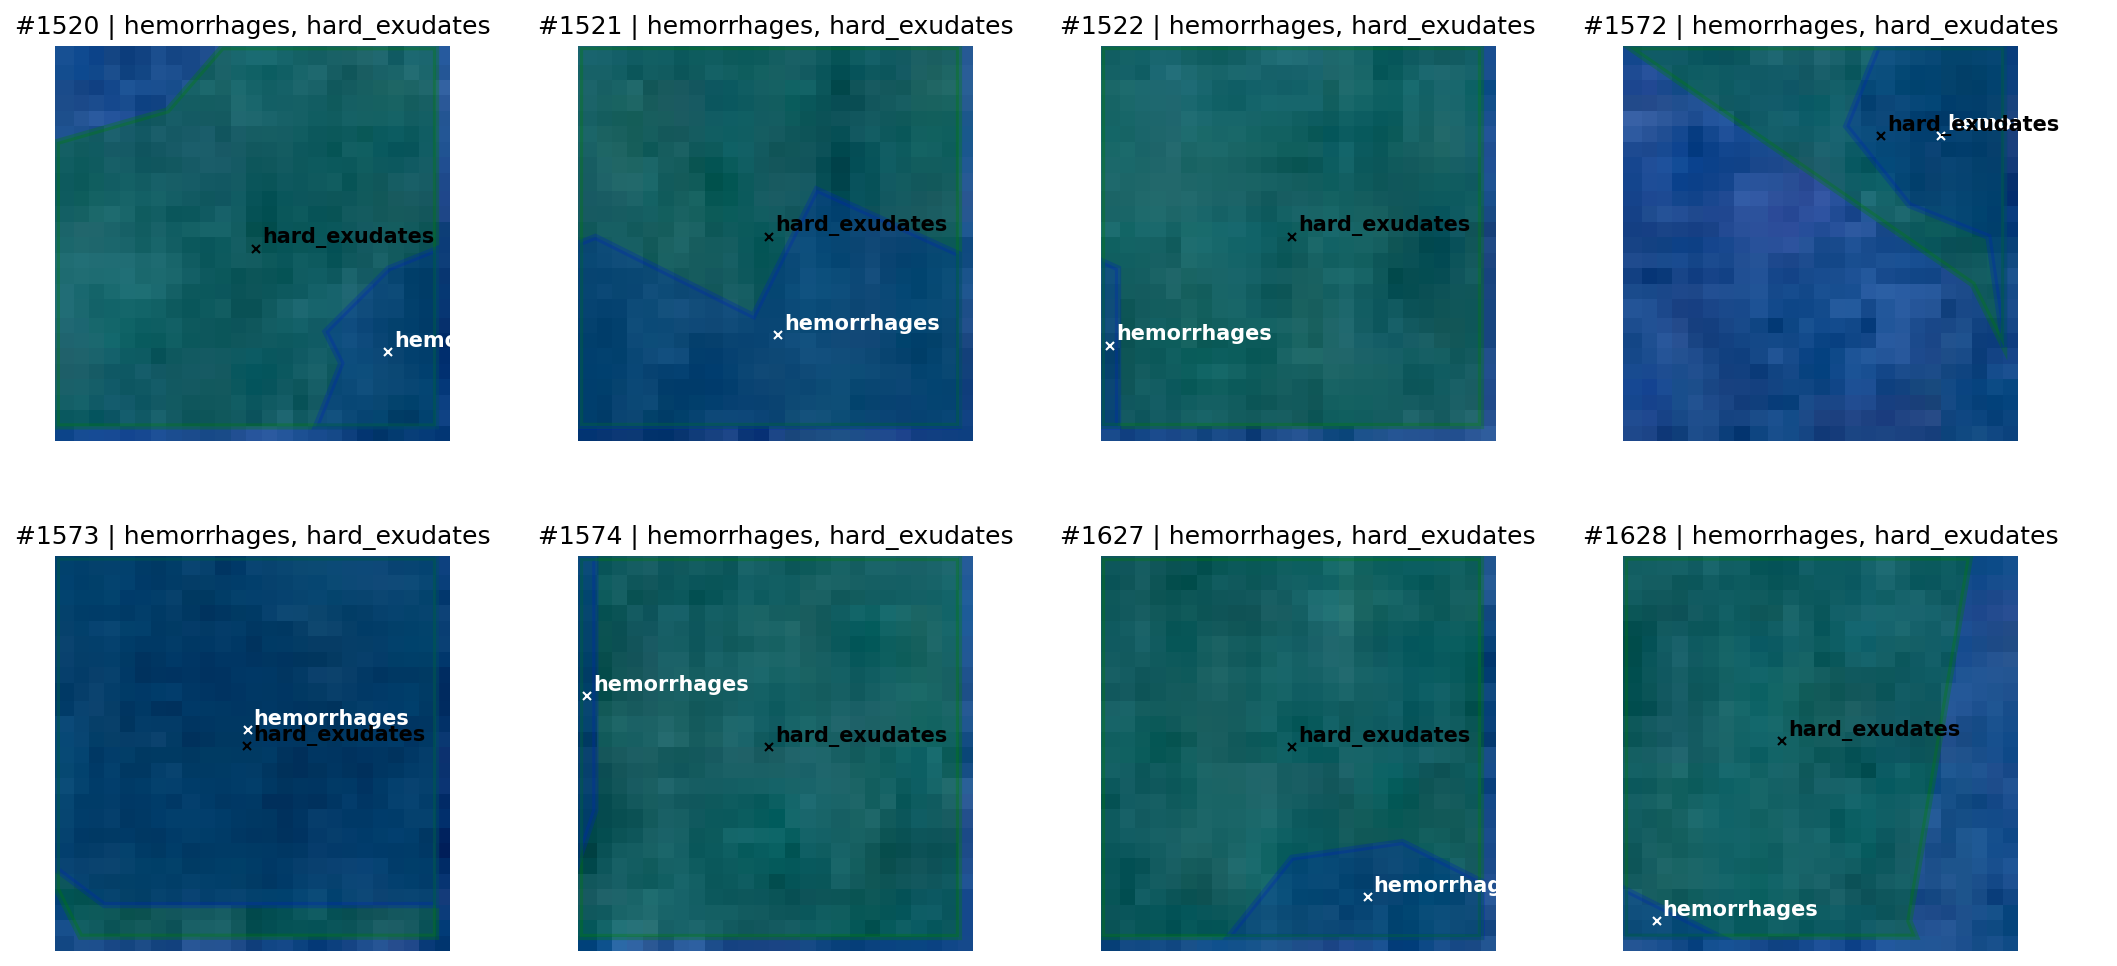

In [10]:
plot_patch_with_lesions(overlapping_df_68.head(8))


#### `0058_1.png`

In [11]:
overlapping_df_58 = final_patches_df_58[
    final_patches_df_58['label'].apply(lambda x: isinstance(x, tuple) and len(x) > 1)
]

display(overlapping_df_58["label"].unique())
display(overlapping_df_58.head(n=2))


array([('hemorrhages', 'hard_exudates'), ('hard_exudates', 'irma'),
       ('hemorrhages', 'irma'), ('microaneurysms', 'irma'),
       ('microaneurysms', 'hemorrhages', 'irma')], dtype=object)

,source_img,patch_no,patch,center,coordinates,label,overlap_flag,patch_polygon,lesion_shape
74,0058_1.png,75,"[[[61, 96, 135], [62, 94, 134], [56, 90, 128],...","(562, 37)","{'top_left': (550, 25), 'top_right': (574, 25)...","(hemorrhages, hard_exudates)",True,"POLYGON ((550 25, 574 25, 574 49, 550 49, 550 ...","[POLYGON ((550 49, 572.9921568627451 49, 550 4..."
124,0058_1.png,125,"[[[40, 75, 115], [38, 73, 112], [36, 71, 109],...","(512, 62)","{'top_left': (500, 50), 'top_right': (524, 50)...","(hemorrhages, hard_exudates)",True,"POLYGON ((500 50, 524 50, 524 74, 500 74, 500 ...","[POLYGON ((524 74, 524 66.90755421040393, 520...."


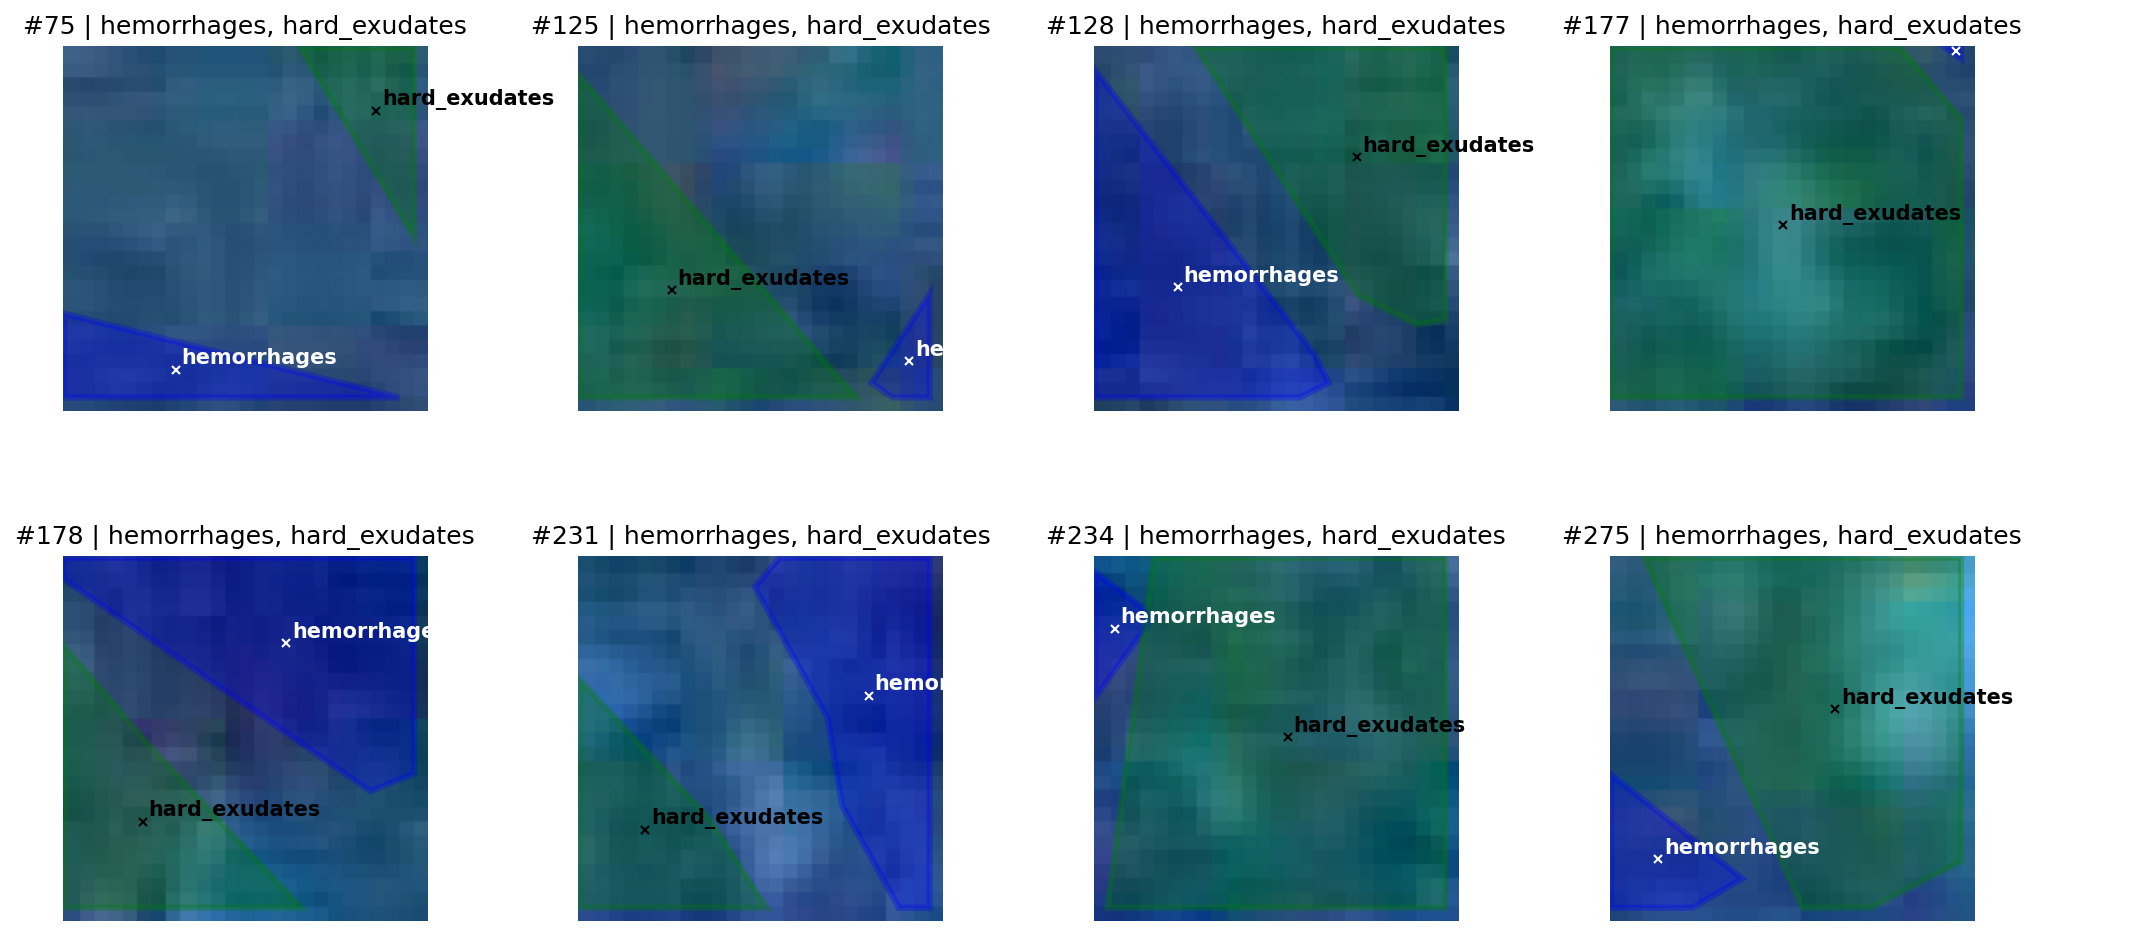

In [12]:
plot_patch_with_lesions(overlapping_df_58.head(8))


#### `0031_2.png`

In [13]:
overlapping_df_31 = final_patches_df_31[
    final_patches_df_31['label'].apply(lambda x: isinstance(x, tuple) and len(x) > 1)
]

display(overlapping_df_31["label"].unique())
display(overlapping_df_31.head(n=2))


array([('hemorrhages', 'soft_exudates'),
       ('microaneurysms', 'hemorrhages')], dtype=object)

,source_img,patch_no,patch,center,coordinates,label,overlap_flag,patch_polygon,lesion_shape
683,0031_2.png,684,"[[[59, 94, 149], [61, 95, 150], [69, 103, 157]...","(187, 337)","{'top_left': (175, 325), 'top_right': (199, 32...","(hemorrhages, soft_exudates)",True,"POLYGON ((175 325, 199 325, 199 349, 175 349, ...","[POLYGON ((199 325, 186.00196078431372 325, 18..."
684,0031_2.png,685,"[[[48, 73, 135], [44, 67, 131], [50, 74, 139],...","(212, 337)","{'top_left': (200, 325), 'top_right': (224, 32...","(hemorrhages, soft_exudates)",True,"POLYGON ((200 325, 224 325, 224 349, 200 349, ...","[POLYGON ((224 349, 224 325, 200 325, 200 343...."


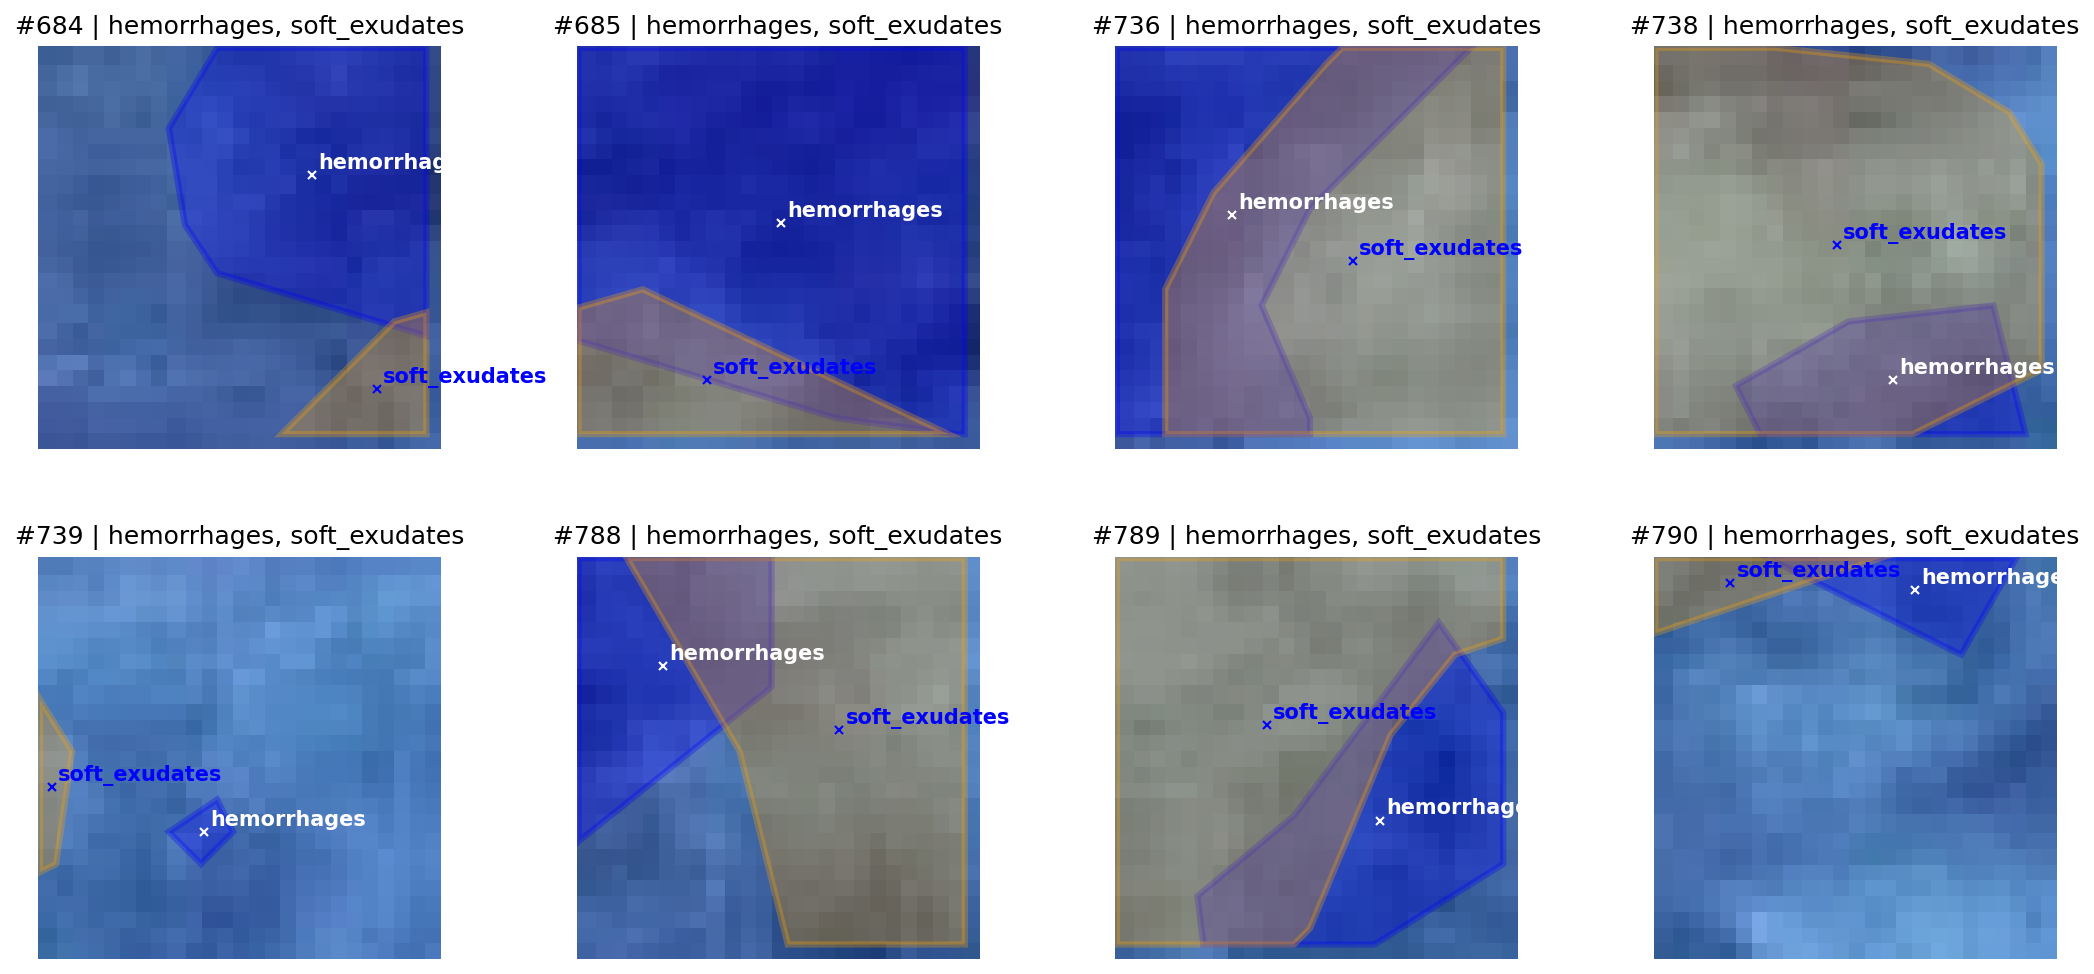

In [14]:
plot_patch_with_lesions(overlapping_df_31.head(8))


## Resolving Labels by Lesion Area Within the Patch

Same principle as before, only adjusted to fit the new dataset. The `build_final_patch_dataframe` function has been modified to resolve the labeling issue by area now. It can be toggled `ON/OFF` using the `resolve_by_area` flag. If set to `True`, the function will resolve the labels based on the area of the lesions within the patch. If set to `False`, it will simply create a tuple with all the lesion labels present in the patch

In [15]:
final_resolved_patches_df_68 = build_final_patch_dataframe(patches_df_68, patch_68_mask_df, resolve_by_area=True)


Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [16]:
final_resolved_patches_df_58 = build_final_patch_dataframe(patches_df_58, patch_58_mask_df, resolve_by_area=True)


Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


In [17]:
final_resolved_patches_df_31 = build_final_patch_dataframe(patches_df_31, patch_31_mask_df, resolve_by_area=True)


Processing images: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


## Results

#### `0068_1.png`

In [18]:
same_patch_ids = overlapping_df_68[['source_img', 'patch_no']]
matching_resolved_df_68 = final_resolved_patches_df_68.merge(
    same_patch_ids, on=['source_img', 'patch_no'], how='inner'
)


#### Before

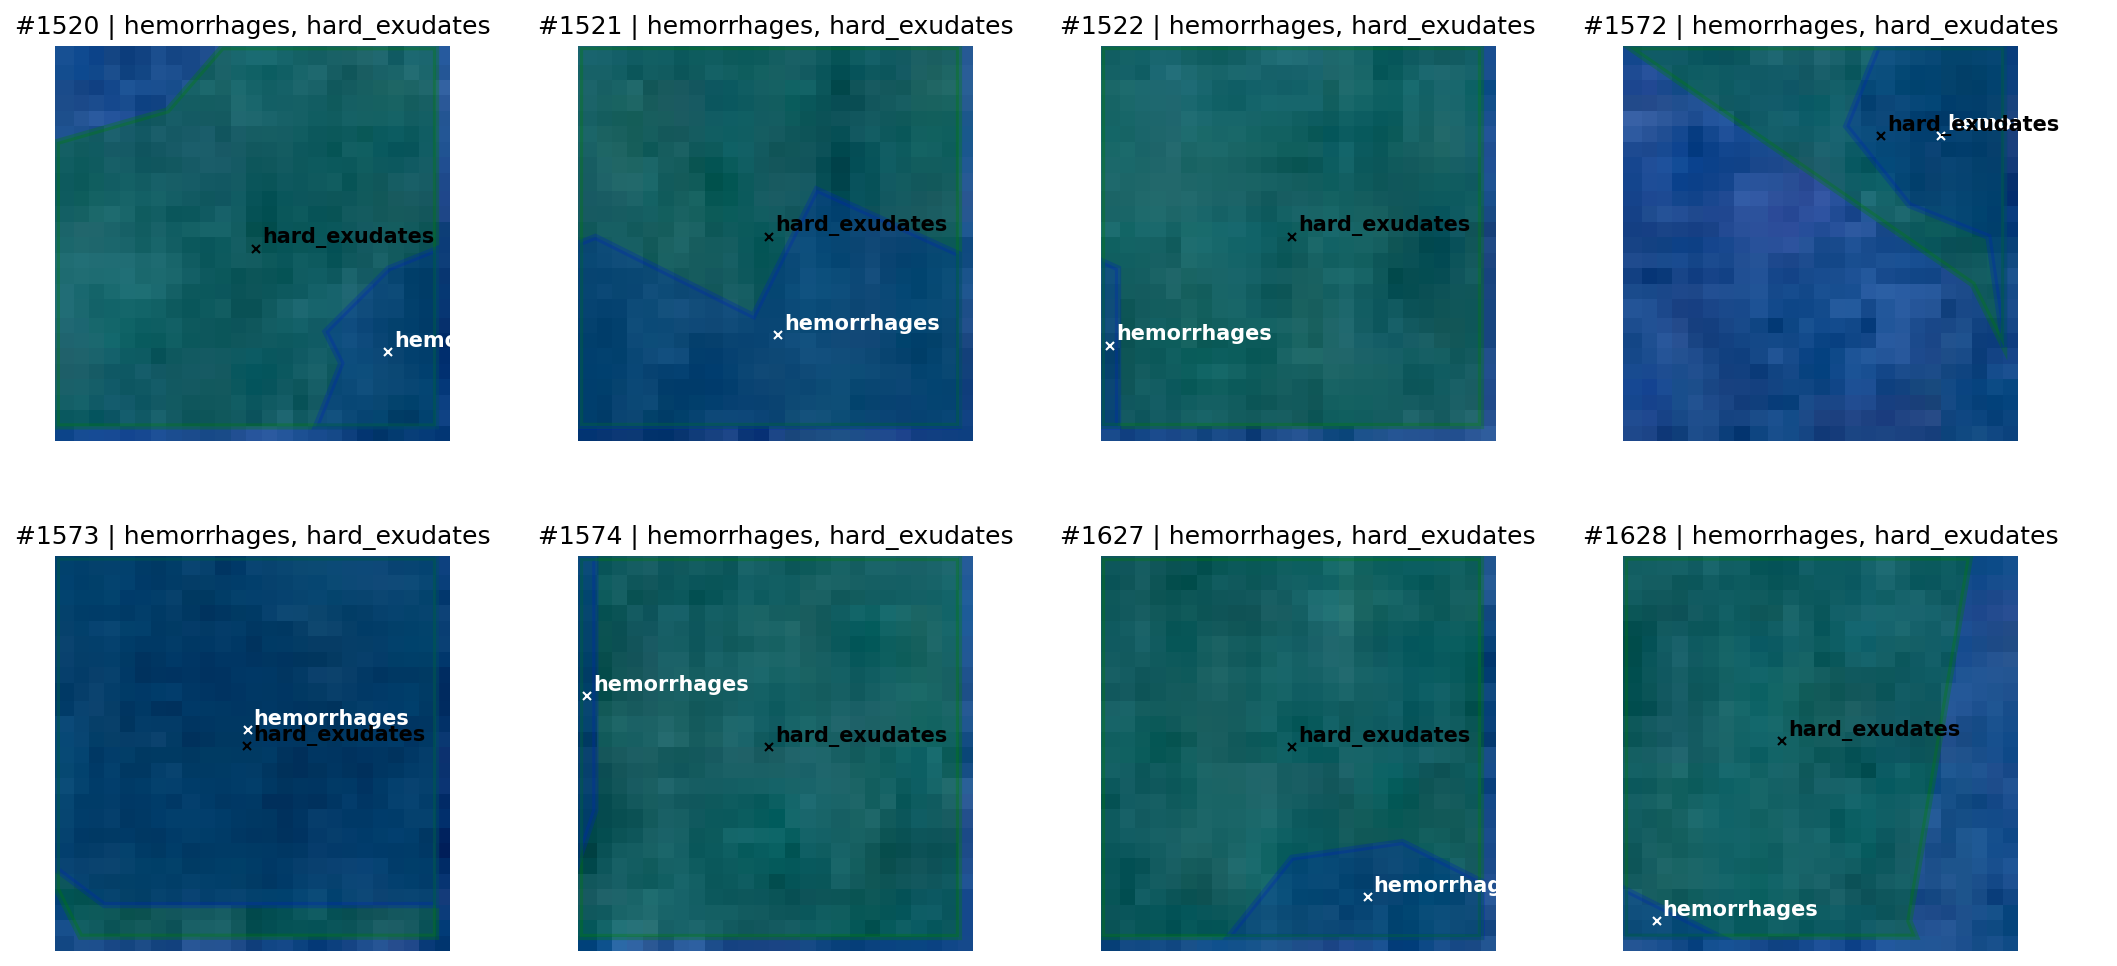

In [19]:
plot_patch_with_lesions(overlapping_df_68.head(8))


#### After

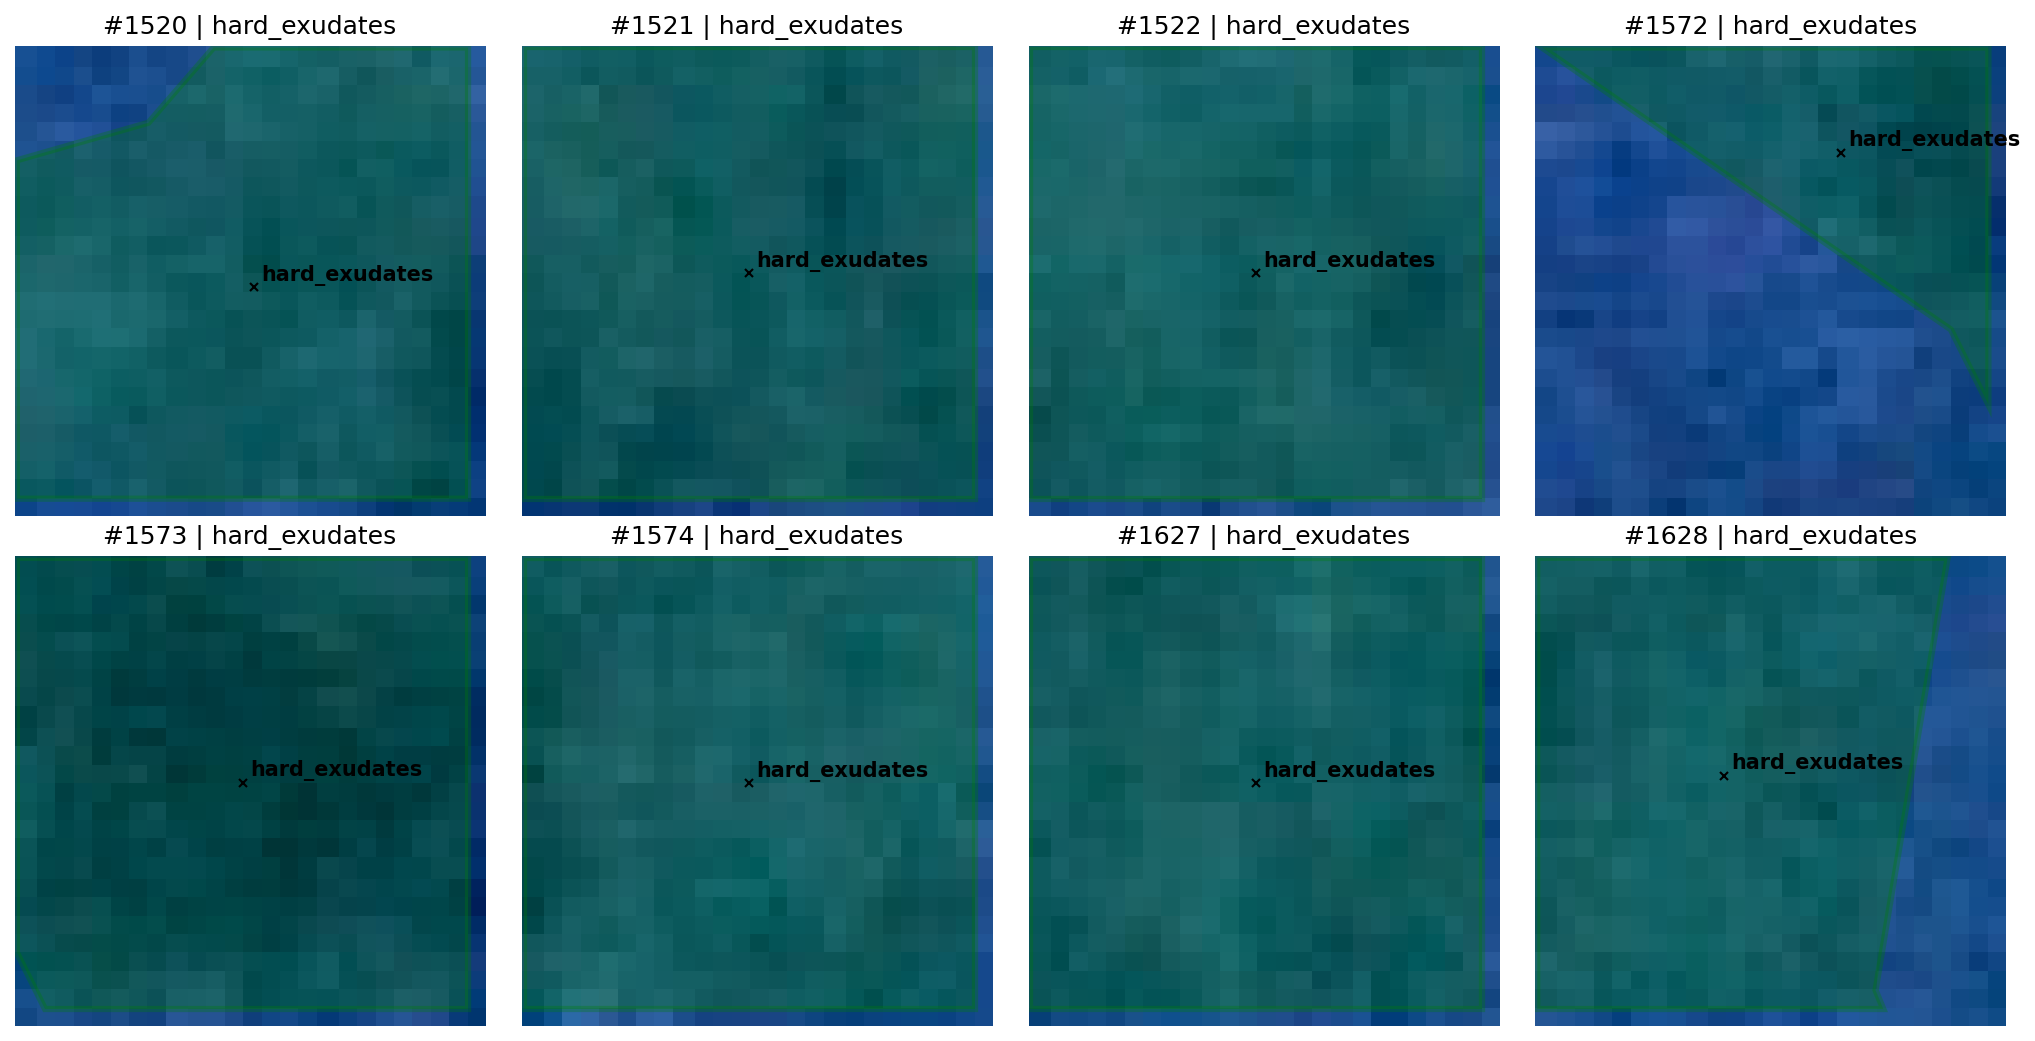

In [20]:
plot_patch_with_lesions(matching_resolved_df_68.head(8))


#### `0058_1.png`

In [21]:
same_patch_ids = overlapping_df_58[['source_img', 'patch_no']]
matching_resolved_df_58 = final_resolved_patches_df_58.merge(
    same_patch_ids, on=['source_img', 'patch_no'], how='inner'
)


#### Before

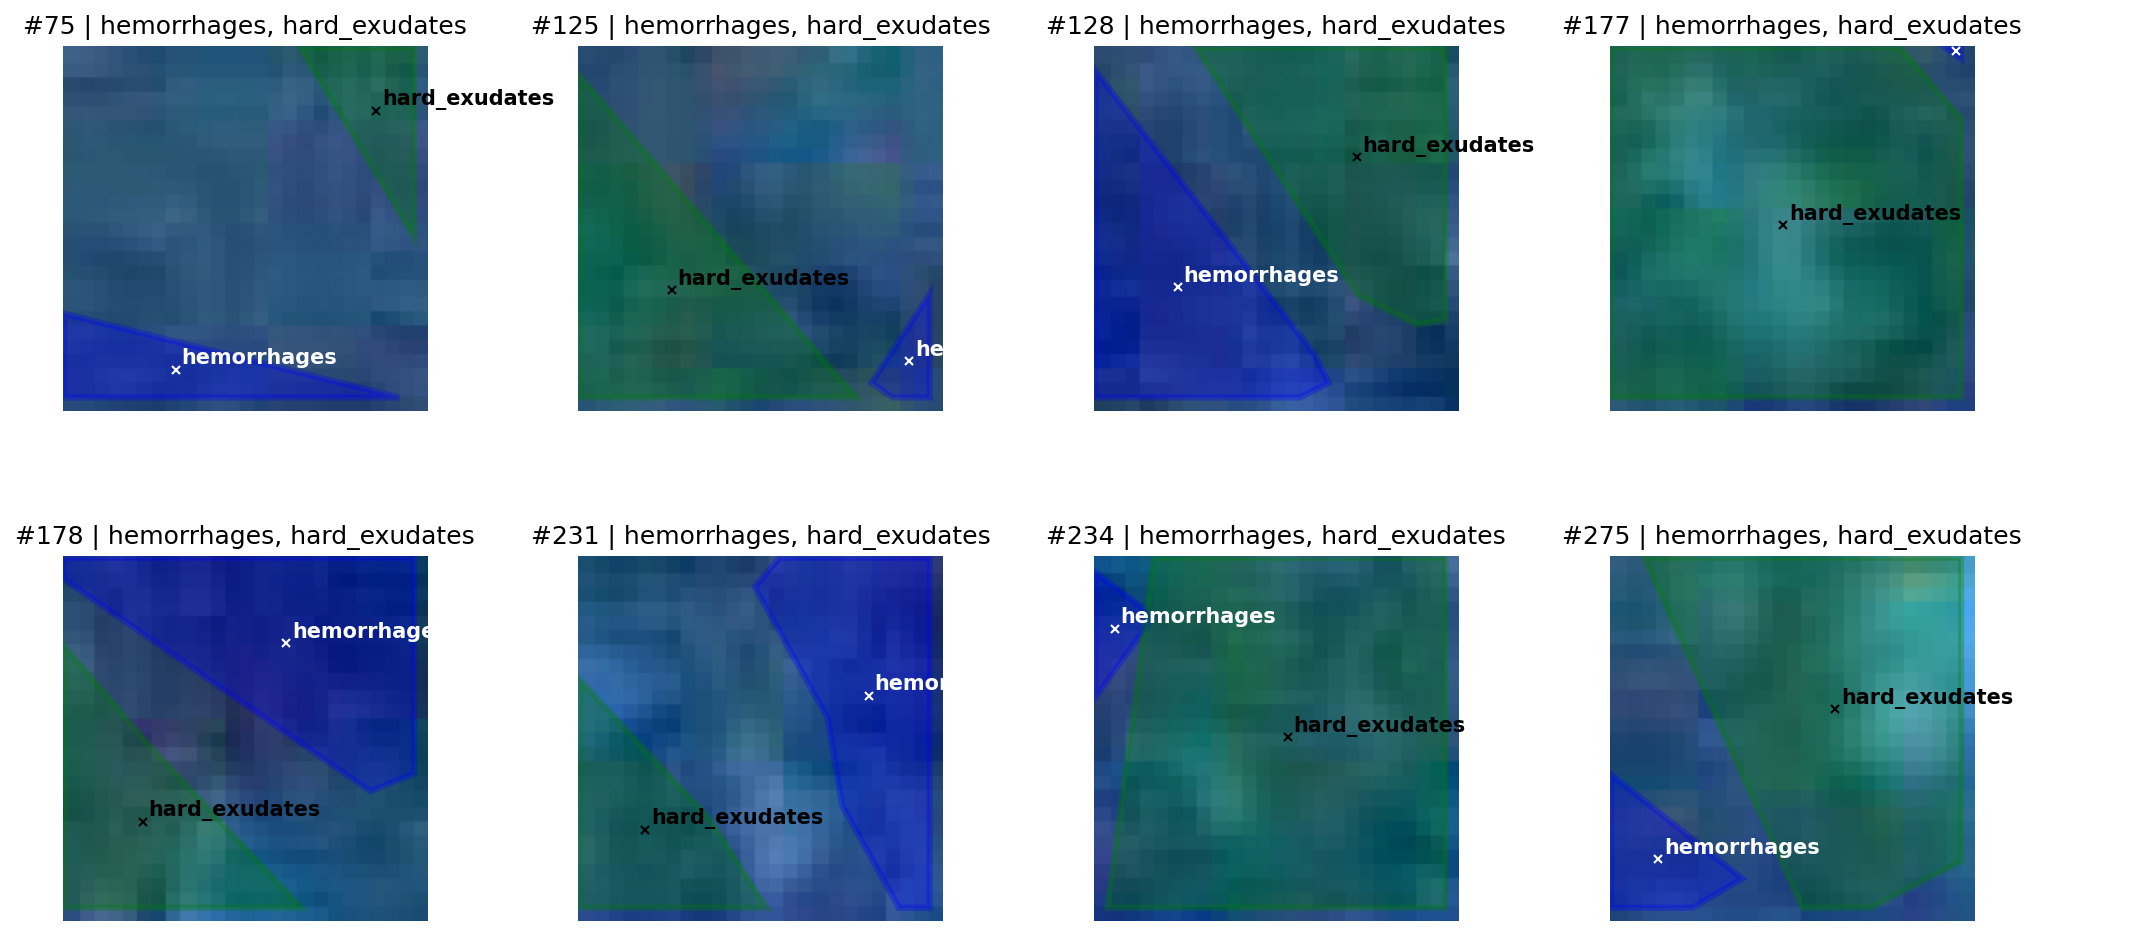

In [22]:
plot_patch_with_lesions(overlapping_df_58.head(8))


#### After

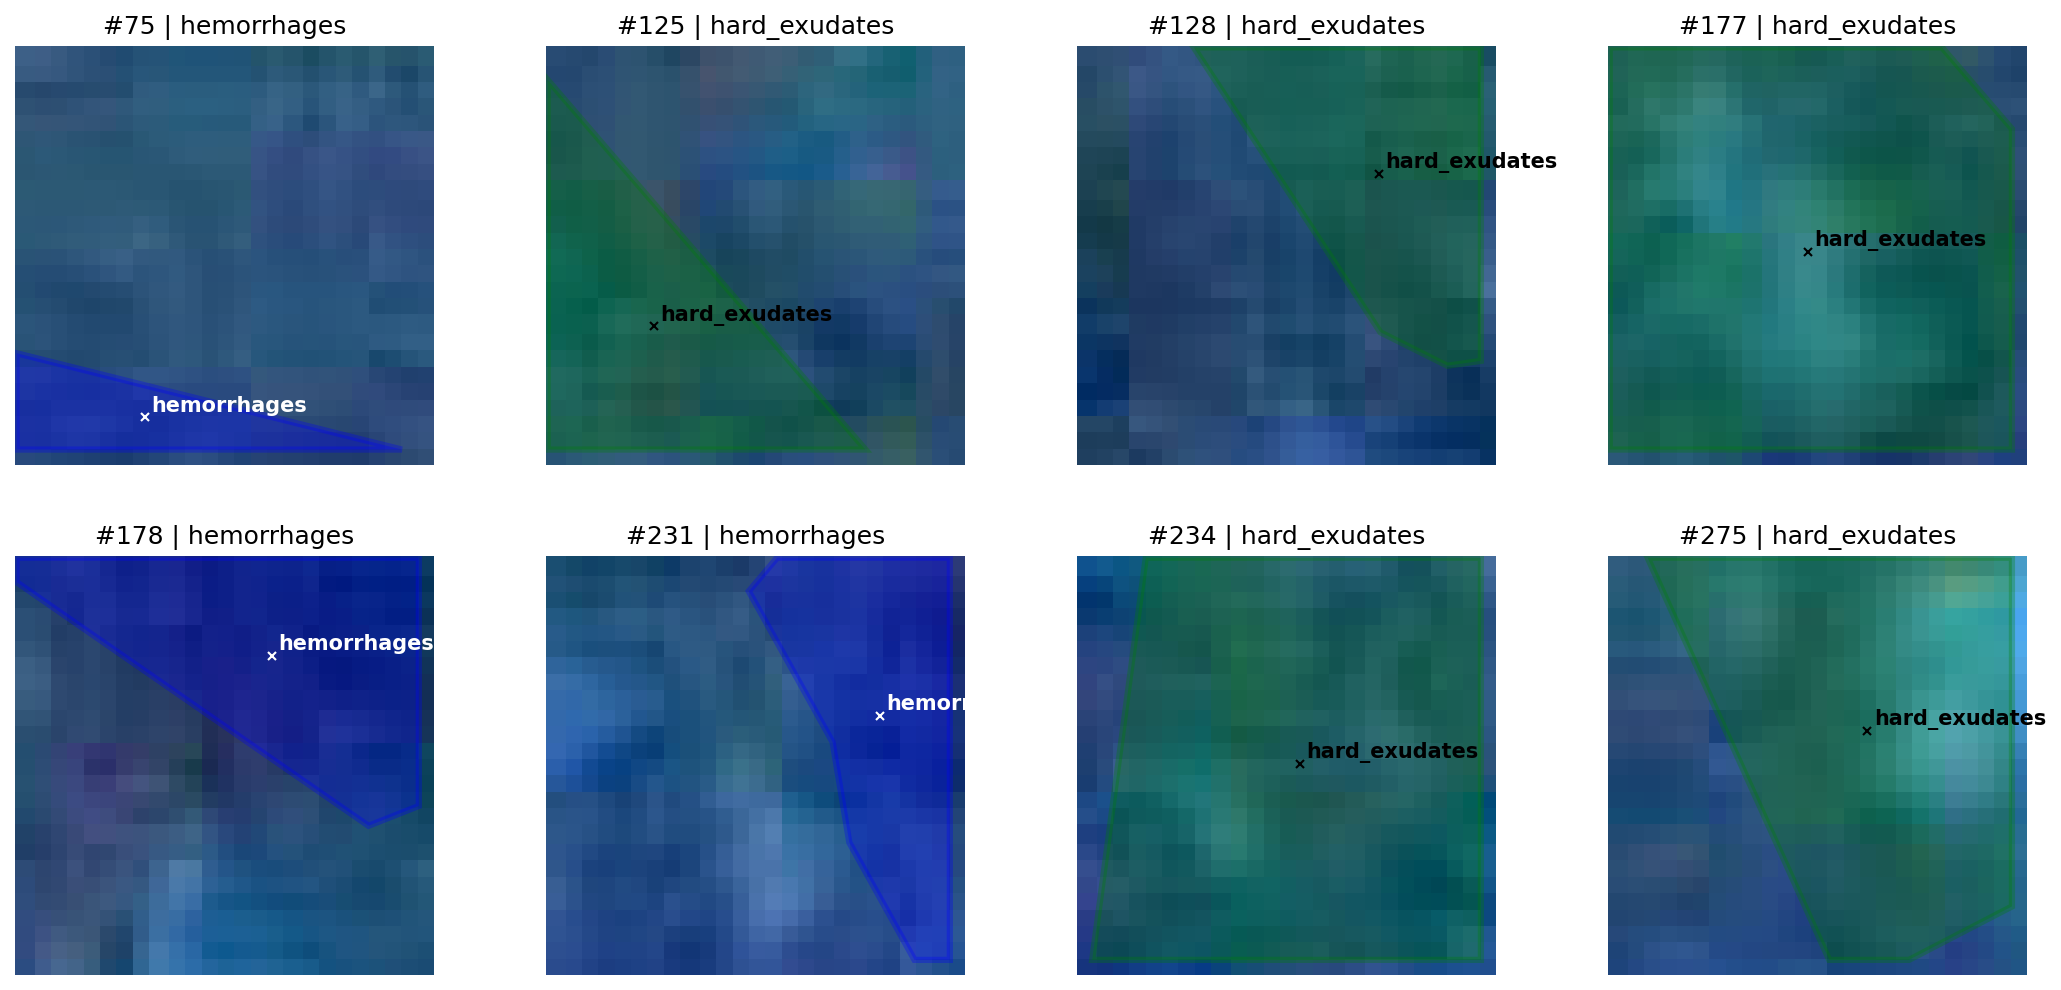

In [23]:
plot_patch_with_lesions(matching_resolved_df_58.head(8))


#### `0031_2.png`

In [24]:
same_patch_ids = overlapping_df_31[['source_img', 'patch_no']]
matching_resolved_df_31 = final_resolved_patches_df_31.merge(
    same_patch_ids, on=['source_img', 'patch_no'], how='inner'
)


#### Before

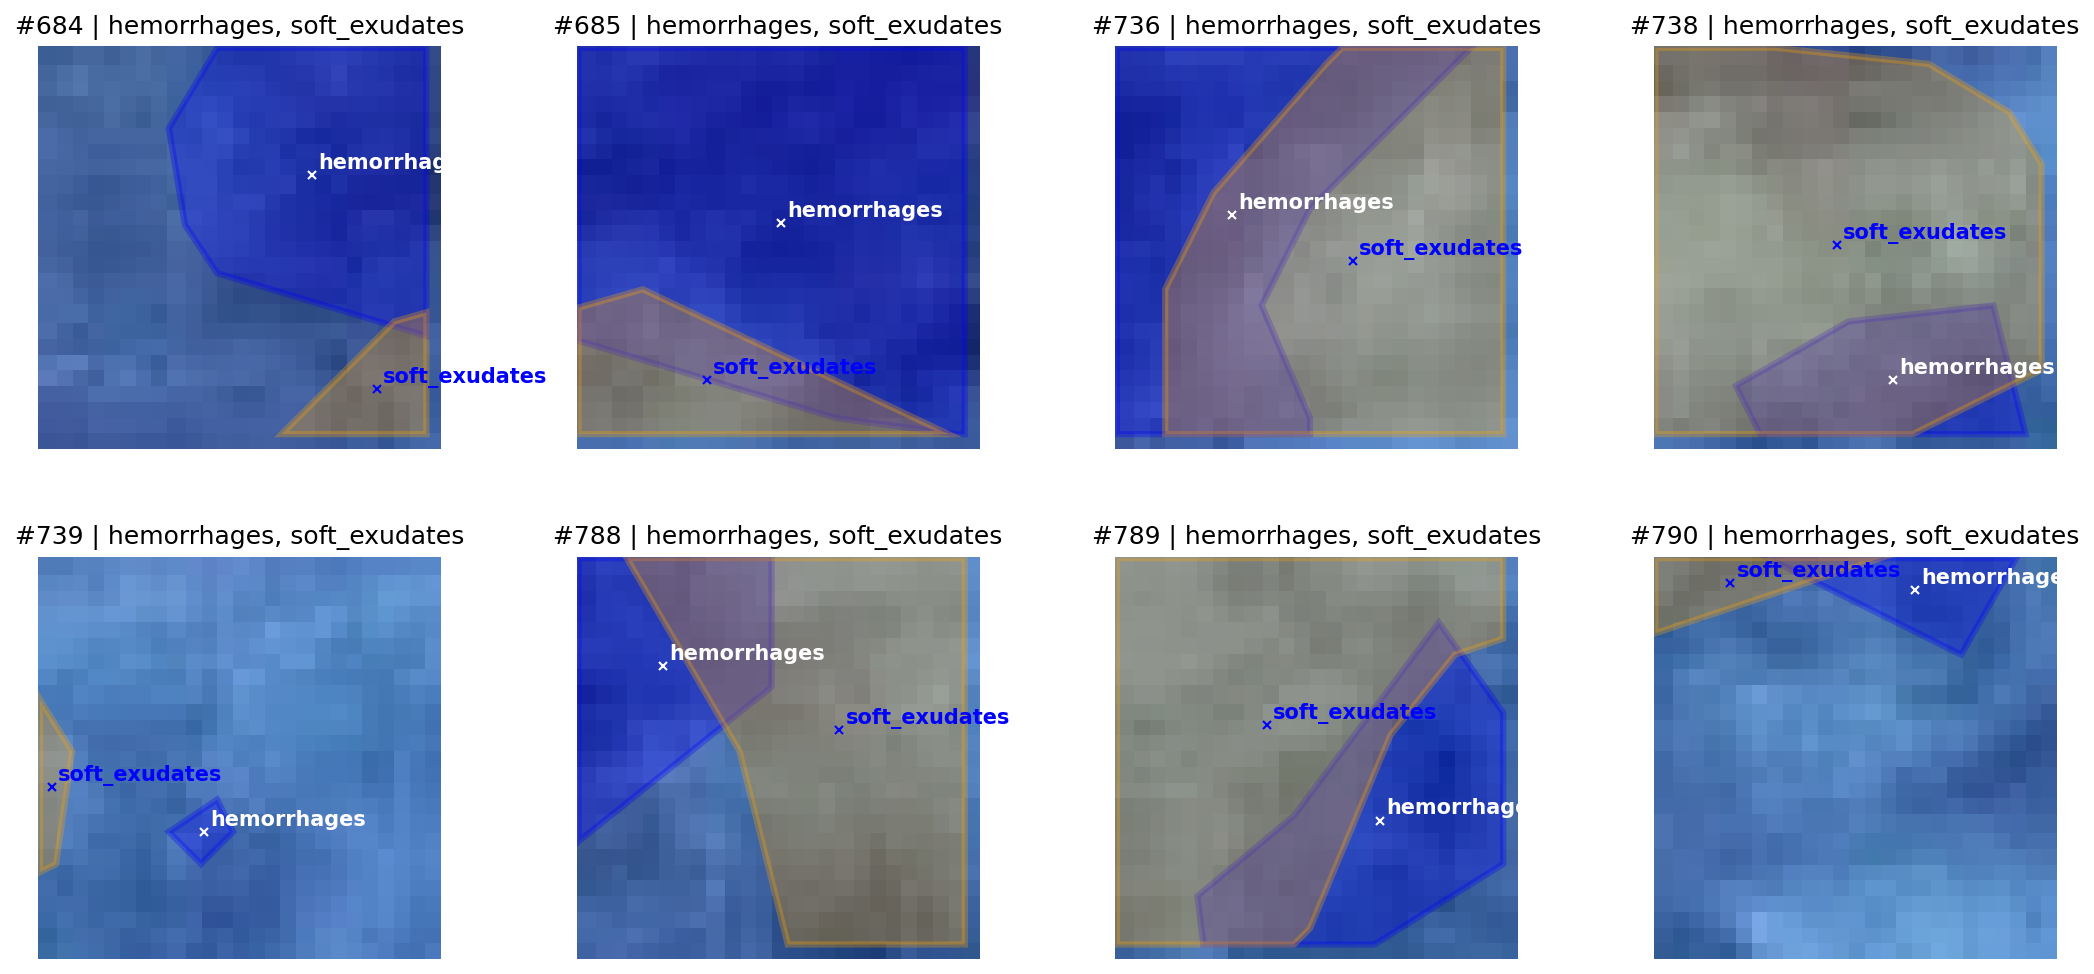

In [25]:
plot_patch_with_lesions(overlapping_df_31.head(8))


#### After

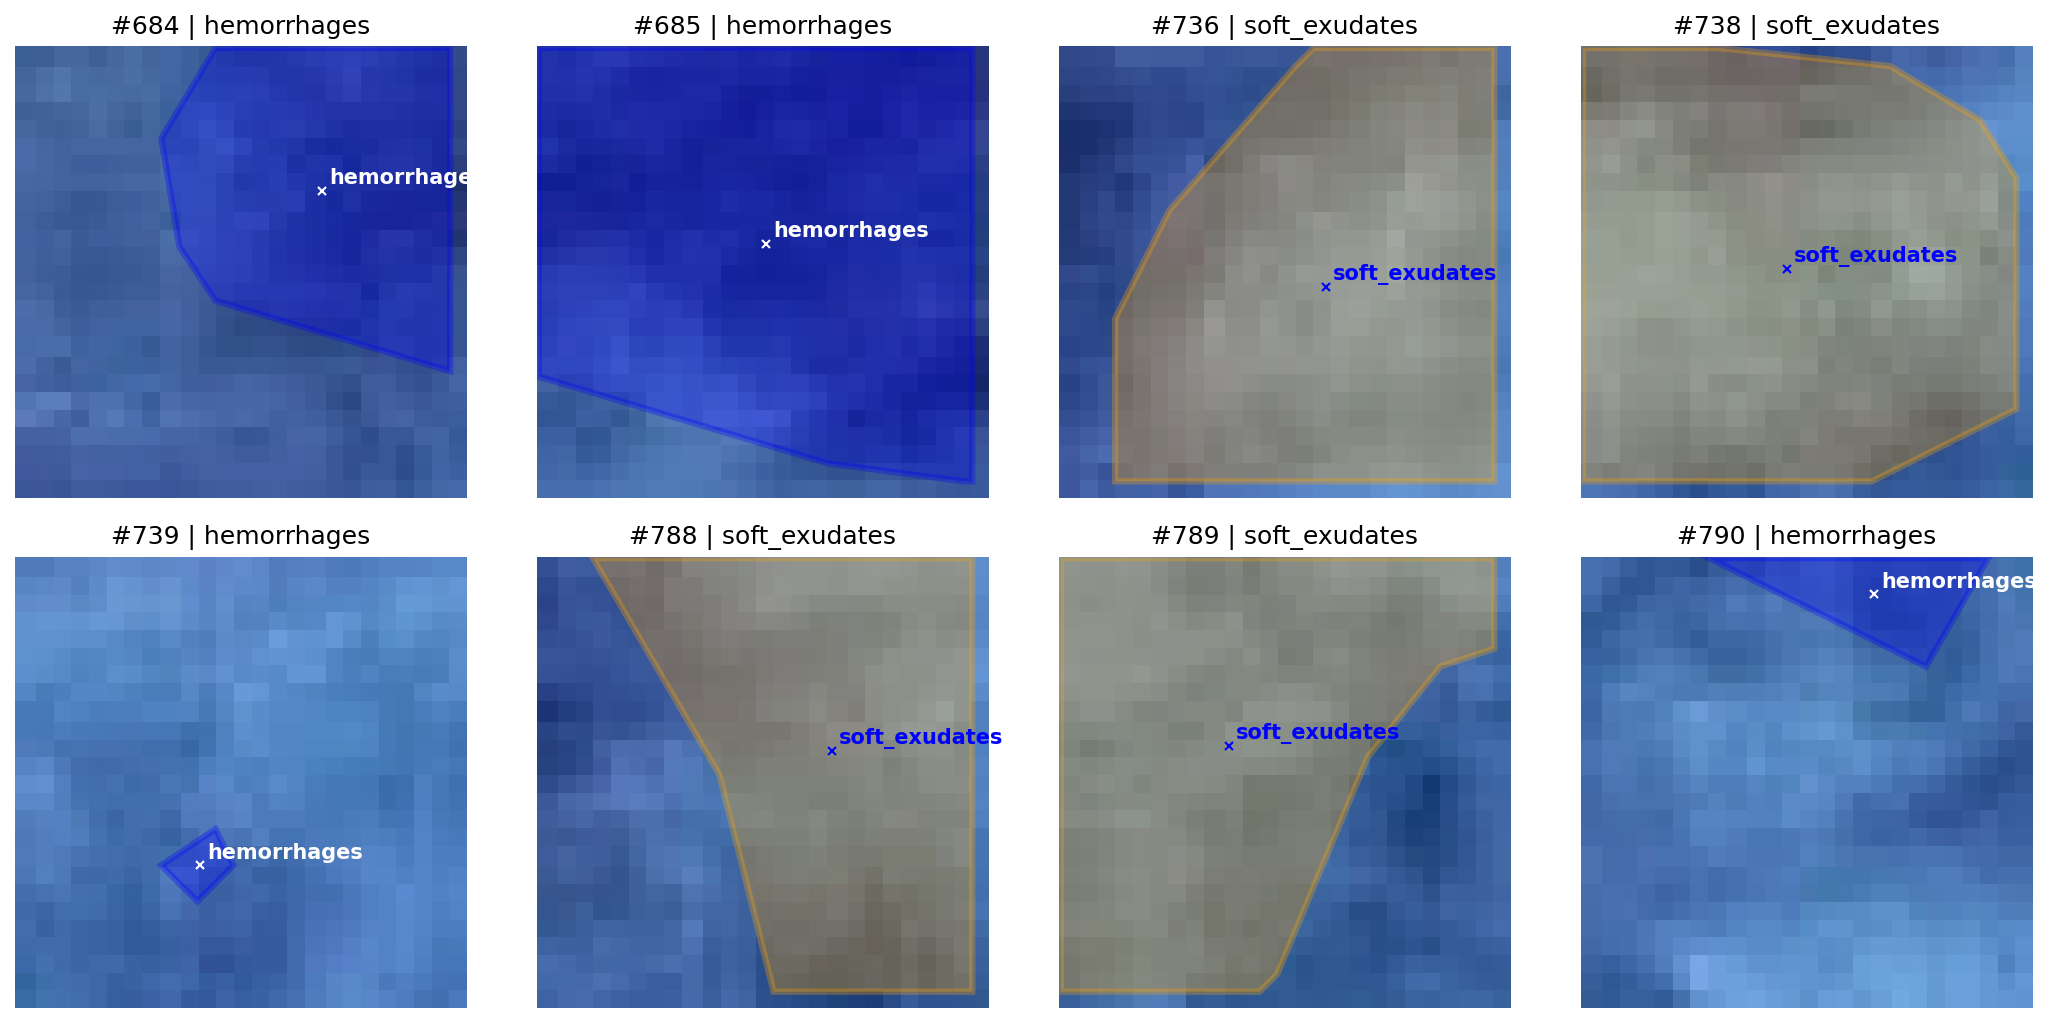

In [26]:
plot_patch_with_lesions(matching_resolved_df_31.head(8))


If you’re staring at this and thinking, “Why does one shape just suck the other one up?”...congrats, you’re just as confused as I was. Turns out, after a bit of digging, the lesions actually do overlap in the original image (makes sense...).

But here’s the kicker...when I use `matplotlib` to slap the patches on top of each other, they stack like a sandwich. So it looks like they’ve got neat little borders and aren’t touching, BUT they are! It’s just a visual trick caused by how the layers are rendered.